# 1 Introduction
This python notebook for Amazon food reviews polarity prediction based on the given review data by applying K Nearest Neighbors (KNN) algorithm. To build generalized prediction model first step should be necessary cleaning of data as a part of data preprocessing. 

We will perform following data preprocessing. 

* Removing Stop-words
* Remove any punctuations or limited set of special characters like , or . or # etc.
* Snowball Stemming the word 
* Convert the word to lowercase
 
Once we the data is cleaned to be processed we'll use below Feature generation techniques to convert text to numeric vector.
1. Bag Of Words (BoW)
1. Term Frequency - inverse document frequency (tf-idf)
1. Word2Vec
1. tf-idf weighted Word2Vec

Using KNN algorithm we will build model to predict review polarity for each technique. 

**Objective: Given a review determine whether a review is positive or negative, by appling KNN algorithm and deciding the best Feature generation technique for given problem.**




**1.1 Load and check data**

In [4]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt
import scikitplot.metrics as skplt
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

import os
#print(os.listdir("../input"))


In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from string import punctuation
from sklearn import svm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from nltk import ngrams
from itertools import chain

In [82]:
type(filtered_data)

pandas.core.frame.DataFrame

In [5]:
import sqlite3
con = sqlite3.connect('C:/Users/Yang Xu/Documents/258 assignmengt 2/database.sqlite')

filtered_data = pd.read_sql_query("""select * from Reviews WHERE Score != 3""",con) # delete data which score =3

filtered_data.shape
filtered_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# 2 Data Preprocessing

*  **Segregating data as positive and negative**

In [208]:
# Here are replacing review score 1,2 as negative and 4,5 as a positive. we are skipping review score 3 considering it as a neutral.
def partition(x):
    if x<3:
        return 'negative'
    return 'positive'

actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition)
filtered_data['Score'] = positiveNegative

* **Sorting data for time based splitting for model train and test dataset**

In [7]:
import datetime

filtered_data["Time"] = filtered_data["Time"].map(lambda t: datetime.datetime.fromtimestamp(int(t)).strftime('%Y-%m-%d %H:%M:%S'))

sortedData = filtered_data.sort_values('ProductId',axis=0,kind="quicksort", ascending=True)
final = sortedData.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep="first",inplace=False)

final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

#As data is huge, due to computation limitation we will randomly select data. we will try to pick data in a way so that it doesn't make data imbalance problem
finalp = final[final.Score == 'positive']
finalp = finalp.sample(frac=0.035,random_state=1) #0.055

finaln = final[final.Score == 'negative']
finaln = finaln.sample(frac=0.15,random_state=1) #0.25

final = pd.concat([finalp,finaln],axis=0)

#sorting data by timestamp so that it can be devided in train and test dataset for time based slicing.
final = final.sort_values('Time',axis=0,kind="quicksort", ascending=True).reset_index(drop=True)


print(final.shape)

(19313, 10)


In [209]:
final = filtered_data

In [210]:
final.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


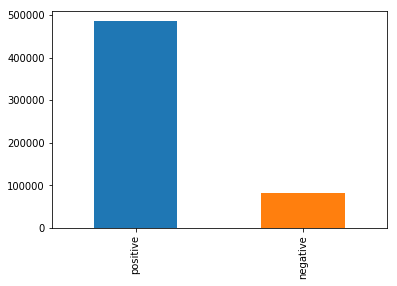

In [211]:
final['Score'].value_counts().plot(kind='bar')

* ** Removing Stop-words **
* ** Remove any punctuations or limited set of special characters like , or . or # etc. **
* ** Snowball Stemming the word ** 
* ** Convert the word to lowercase **

In [197]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''

final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words    
    final_string.append(str1)
    i+=1

Look some basic information for the data

1. data size

In [198]:
len(final)

19313

In [144]:
sno

# 3 Building function to find optimal K for KNN

**To Find the optimal K we will used 10 fold cross validation method. Based on misclassifiction error for every K, we will decide the best K on  Train Data**

In [55]:
np.array(range(10)) +1

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [58]:
from sklearn.cross_validation import cross_val_score

def find_optimal_k(X_train,y_train, myList):
   
    #creating odd list of K for KNN
    #myList = list(range(0,10))
    #neighbors = list(filter(lambda x: x % 2 != 0, myList))
    neighbors = np.array(myList) +1

    # empty list that will hold cv scores
    cv_scores = []

    # perform 5-fold cross validation
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[MSE.index(min(MSE))]
    print('\nThe optimal number of neighbors is %d.' % optimal_k)


    plt.figure(figsize=(10,6))
    plt.plot(neighbors,MSE,color='blue', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=10)
    plt.title('Error Rate vs. K Value')
    plt.xlabel('K')
    plt.ylabel('Error Rate')

    print("the misclassification error for each k value is : ", np.round(MSE,4))
    
    return optimal_k

# 4 Feature generation techniques to convert text to numeric vector.[](http://) 

# 4.1 Appling KNN with BoW

**Generating Bag of Wrods Vector matrix for Reviews**

In [42]:
from sklearn.feature_extraction.text import CountVectorizer

#count_vect = CountVectorizer(ngram_range=(1,2) ) 
count_vect = CountVectorizer() 
final_bow_count = count_vect.fit_transform(final_string)#final['Text'].values)

In [43]:
from sklearn.preprocessing import StandardScaler

final_bow_np = StandardScaler(with_mean=False).fit_transform(final_bow_count )


C:\Users\Yang Xu\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


**Splitting Data into Train and Test based on the timestamp of review**

In [44]:
#We already have sorted data by timestamp so we will use first 70% of data as Train with cross validation and next 30% for test
import math
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X = final_bow_np
y = final['Score']

X_train =  final_bow_np[:math.ceil(len(final)*.7)] 
X_test = final_bow_np[math.ceil(len(final)*.7):]
y_train = y[:math.ceil(len(final)*.7)]
y_test =  y[math.ceil(len(final)*.7):]

In [51]:
X_train

<13520x18050 sparse matrix of type '<class 'numpy.float64'>'
	with 431882 stored elements in Compressed Sparse Row format>

**Finding Optimal K by 5 fold Cross validation**


The optimal number of neighbors is 6.
the misclassification error for each k value is :  [0.3785 0.3766 0.3494 0.3365 0.3459 0.3322 0.3568 0.3431 0.3672 0.3525]


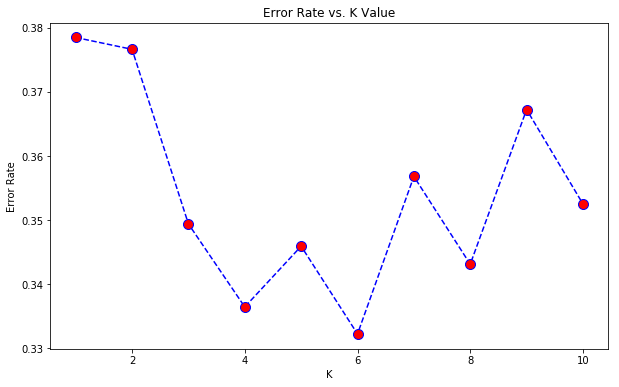

In [59]:
myList = list(range(0,10))

optimal_k = find_optimal_k(X_train ,y_train,myList)



In [60]:
print(optimal_k)

6


**KNN with Optimal K**

In [61]:
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

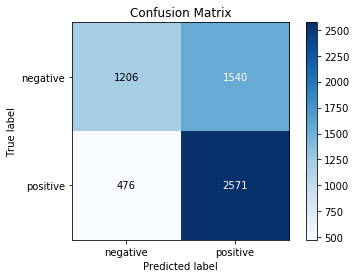

In [62]:
skplt.plot_confusion_matrix(y_test ,pred)

In [63]:
print(classification_report(y_test ,pred))

             precision    recall  f1-score   support

   negative       0.72      0.44      0.54      2746
   positive       0.63      0.84      0.72      3047

avg / total       0.67      0.65      0.64      5793



In [64]:
print("Accuracy for KNN model with Bag of words is ",round(accuracy_score(y_test ,pred),3))

Accuracy for KNN model with Bag of words is  0.652


# 4.2 Appling KNN with tf-idf

**Generating tf-idf Vector matrix for Reviews**

In [65]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vec = TfidfVectorizer()#ngram_range=(2,2))

final_tfidf_count = tf_idf_vec.fit_transform(final_string)#final['Text'].values)

#print(final_string)

In [66]:
from sklearn.preprocessing import StandardScaler

final_tfidf_np = StandardScaler(with_mean=False).fit_transform(final_tfidf_count )


**Splitting Data into Train and Test**

In [67]:
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split

X = final_tfidf_np
y = final['Score']

X_train =  final_tfidf_np[:math.ceil(len(final)*.7)] 
X_test = final_tfidf_np[math.ceil(len(final)*.7):]
y_train = y[:math.ceil(len(final)*.7)]
y_test =  y[math.ceil(len(final)*.7):]


The optimal number of neighbors is 4.
the misclassification error for each k value is :  [0.4136 0.4236 0.4053 0.3956 0.4135 0.4038 0.4201 0.4133 0.4251 0.4239]


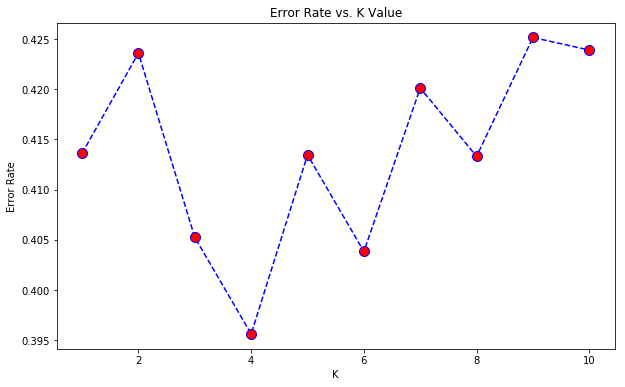

In [68]:
myList = list(range(0,10))

optimal_k = find_optimal_k(X_train ,y_train,myList)


**KNN with Optimal K**

In [69]:
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

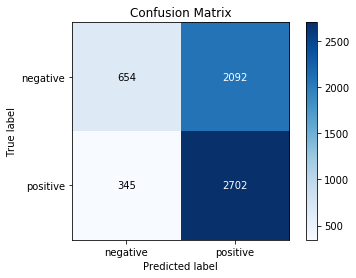

In [70]:
skplt.plot_confusion_matrix(y_test ,pred)

In [71]:
print(classification_report(y_test ,pred))

             precision    recall  f1-score   support

   negative       0.65      0.24      0.35      2746
   positive       0.56      0.89      0.69      3047

avg / total       0.61      0.58      0.53      5793



In [72]:
print("Accuracy for KNN model with tf-idf is ",round(accuracy_score(y_test ,pred),3))

Accuracy for KNN model with tf-idf is  0.579


## 4.3 Appling KNN to rating data by BoW

In [194]:
data2 = final1.iloc[:,[6,9]]
data2.head()

,Score,Text
0,5,I have bought several of the Vitality canned d...
1,1,Product arrived labeled as Jumbo Salted Peanut...
2,4,This is a confection that has been around a fe...
3,2,If you are looking for the secret ingredient i...
4,5,Great taffy at a great price. There was a wid...


In [199]:
i=0
str1=' '
final_string=[]
s=''

for sent in data2['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words    
    final_string.append(str1)
    i+=1

In [200]:
count_vect = CountVectorizer() 
final_bow_count = count_vect.fit_transform(final_string)#final['Text'].values)
final_bow_np = StandardScaler(with_mean=False).fit_transform(final_bow_count )

C:\Users\Yang Xu\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [201]:
X = final_bow_np
y = data2['Score']

X_train =  final_bow_np[:math.ceil(len(data2)*.7)] 
X_test = final_bow_np[math.ceil(len(data2)*.7):]
y_train = y[:math.ceil(len(data2)*.7)]
y_test =  y[math.ceil(len(data2)*.7):]

In [215]:
X_train

<397918x74579 sparse matrix of type '<class 'numpy.float64'>'
	with 12753786 stored elements in Compressed Sparse Row format>

In [219]:
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train[:10000], y_train[:10000])
pred = knn.predict(X_test)

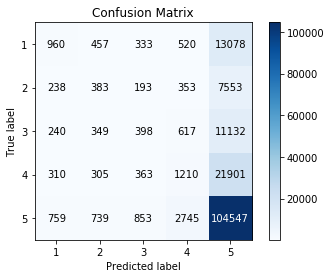

In [221]:
skplt.plot_confusion_matrix(y_test ,pred)

In [220]:
print("Accuracy for KNN model with Bag of words is ",round(accuracy_score(y_test ,pred),3))

Accuracy for KNN model with Bag of words is  0.63


## Train a Baseline Model

Use the latent factor model to make a simple predictor.

In [175]:
final1 = final.copy()

In [80]:
type(con)

sqlite3.Connection

In [183]:

final1 = pd.read_sql_query("""select * from Reviews""",con)

final1.shape
final1.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [85]:
df = final1.sample(frac=1).reset_index(drop=True)

In [86]:
len(df)

568454

In [92]:
train = df.head(400000)
validation = df.tail(len(df)-len(train))

In [99]:
y_train = list(train['Score'])
y_test = list(validation['Score'])

In [100]:
alpha = np.mean(y_train)


In [103]:
def predict(alpha):
    return alpha

def mse(predictions, y):
    return np.dot((predictions-y), (predictions-y).T) / float(len(df))


In [122]:
predictions = [alpha]*len(y_test)
MSE = sum((np.array(predictions)-np.array(y_test))**2)/len(y_test)

In [123]:
print ("MSE =", MSE)
print("alpha =", alpha)

MSE = 1.7096849194922645
alpha = 4.1813325


Above is the MSE and $\alpha$ for trivial predictor

## Logistic regression on tf-idf

In [126]:
len(final1)

568454

In [128]:
odf = pd.read_csv('C:/Users/Yang Xu/Documents/258 assignmengt 2/Reviews.csv')
odf['Helpful %'] = np.where(odf['HelpfulnessDenominator'] > 0, odf['HelpfulnessNumerator'] / odf['HelpfulnessDenominator'], -1)
odf['% Upvote'] = pd.cut(odf['Helpful %'], bins = [-1, 0, 0.2, 0.4, 0.6, 0.8, 1.0], labels = ['Empty', '0-20%', '20-40%', '40-60%', '60-80%', '80-100%'], include_lowest = True)
odf.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpful %,% Upvote
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,80-100%
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,-1.0,Empty
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0,80-100%
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0,80-100%
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,-1.0,Empty


Text(0.5,1,'How helpful users find among user scores')

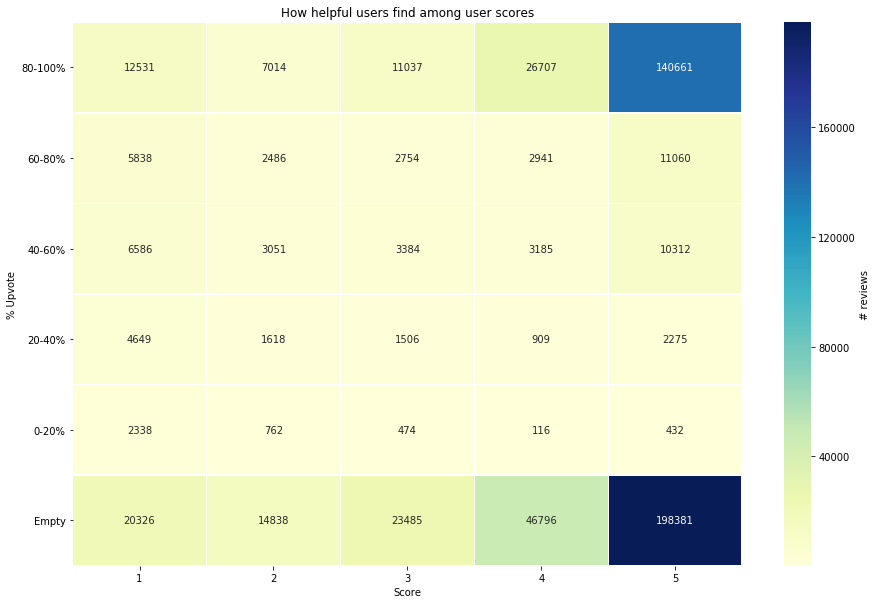

In [129]:
df_s = odf.groupby(['Score', '% Upvote']).agg({'Id': 'count'})
df_s = df_s.unstack()
df_s.columns = df_s.columns.get_level_values(1)
fig = plt.figure(figsize=(15,10))

sns.heatmap(df_s[df_s.columns[::-1]].T, cmap = 'YlGnBu', linewidths=.5, annot = True, fmt = 'd', cbar_kws={'label': '# reviews'})
plt.yticks(rotation=0)
plt.title('How helpful users find among user scores')

In [130]:
df = odf[odf['Score'] != 3]
X = df['Text']
y_dict = {1:0, 2:0, 4:1, 5:1} # 1,2 are negative, 4,5 are positive
y = df['Score'].map(y_dict)

In [132]:
y[:10]

0    1
1    0
2    1
3    0
4    1
5    1
6    1
7    1
8    1
9    1
Name: Score, dtype: int64

## Prediction for score

In [173]:
X

0         I have bought several of the Vitality canned d...
1         Product arrived labeled as Jumbo Salted Peanut...
2         This is a confection that has been around a fe...
3         If you are looking for the secret ingredient i...
4         Great taffy at a great price.  There was a wid...
5         I got a wild hair for taffy and ordered this f...
6         This saltwater taffy had great flavors and was...
7         This taffy is so good.  It is very soft and ch...
8         Right now I'm mostly just sprouting this so my...
9         This is a very healthy dog food. Good for thei...
10        I don't know if it's the cactus or the tequila...
11        One of my boys needed to lose some weight and ...
12        My cats have been happily eating Felidae Plati...
13        good flavor! these came securely packed... the...
14        The Strawberry Twizzlers are my guilty pleasur...
15        My daughter loves twizzlers and this shipment ...
16        I love eating them and they ar

In [172]:
c.fit_transform(X)

<525814x114969 sparse matrix of type '<class 'numpy.int64'>'
	with 15966096 stored elements in Compressed Sparse Row format>

### Logistic regression model on word count

In [133]:
c = CountVectorizer(stop_words = 'english')

def text_fit(X, y, model,clf_model,coef_show=1):
    
    X_c = model.fit_transform(X)
    print('# features: {}'.format(X_c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=0)
    print('# train records: {}'.format(X_train.shape[0]))
    print('# test records: {}'.format(X_test.shape[0]))
    clf = clf_model.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    print ('Model Accuracy: {}'.format(acc))
    
    if coef_show == 1: 
        w = model.get_feature_names()
        coef = clf.coef_.tolist()[0]
        coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
        coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
        print('')
        print('-Top 20 positive-')
        print(coeff_df.head(20).to_string(index=False))
        print('')
        print('-Top 20 negative-')        
        print(coeff_df.tail(20).to_string(index=False))
    
    
text_fit(X, y, c, LogisticRegression())

# features: 114969
# train records: 394360
# test records: 131454
Model Accuracy: 0.9387314193558203

-Top 20 positive-
Coefficient           Word
   3.327643     pleasantly
   3.189435  emeraldforest
   3.001346        chedder
   2.559193        easiest
   2.447070        solving
   2.433008        blowout
   2.370716      addicting
   2.368502       heartier
   2.292219     unwrapping
   2.291049       drawback
   2.289582         hooked
   2.288130          herrs
   2.266416         skewed
   2.259576         hahaha
   2.249479       downside
   2.231996     correction
   2.187727          whisk
   2.184127         ration
   2.181312         bertie
   2.165358     dishwasher

-Top 20 negative-
Coefficient           Word
  -2.465001         ripoff
  -2.489595       tastless
  -2.592699        weakest
  -2.599600      overrated
  -2.691895      cancelled
  -2.729232    unappealing
  -2.737504        furious
  -2.751046     oversalted
  -2.821837      deceptive
  -2.822017  disappointi

In [174]:
c = CountVectorizer(stop_words = 'english',ngram_range = (2,2))

def text_fit(X, y, model,clf_model,coef_show=1):
    
    X_c = model.fit_transform(X)
    print('# features: {}'.format(X_c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=0)
    print('# train records: {}'.format(X_train.shape[0]))
    print('# test records: {}'.format(X_test.shape[0]))
    clf = clf_model.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    print ('Model Accuracy: {}'.format(acc))
    
    if coef_show == 1: 
        w = model.get_feature_names()
        coef = clf.coef_.tolist()[0]
        coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
        coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
        print('')
        print('-Top 20 positive-')
        print(coeff_df.head(20).to_string(index=False))
        print('')
        print('-Top 20 negative-')        
        print(coeff_df.tail(20).to_string(index=False))
    
    
text_fit(X, y, c, LogisticRegression())

# features: 3818210
# train records: 394360
# test records: 131454
Model Accuracy: 0.9456844219270619

-Top 20 positive-
Coefficient                  Word
   3.107806  pleasantly surprised
   2.905187      highly recommend
   2.542724    highly recommended
   2.237856            just right
   2.111330      absolutely loves
   2.106243           simply best
   2.084511      definitely order
   2.055360              far best
   2.048290          great flavor
   2.028811          perfect size
   2.005918            love stuff
   2.003662            just loves
   1.990548            best price
   1.977804         fast shipping
   1.965511           stop eating
   1.954879          just perfect
   1.948791           great stuff
   1.938226             don worry
   1.901633             just love
   1.899034           worth penny

-Top 20 negative-
Coefficient                  Word
  -2.610969            threw rest
  -2.626043          wasted money
  -2.637356     false advertising
  -2.67162

In [134]:
text_fit(X, y, c, DummyClassifier(),0)

# features: 114969
# train records: 394360
# test records: 131454
Model Accuracy: 0.7373225615044046


1. data size

In [140]:
c

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [137]:
c.fit_transform(X)

<525814x114969 sparse matrix of type '<class 'numpy.int64'>'
	with 15966096 stored elements in Compressed Sparse Row format>

In [139]:
c.fit_transform(X).shape

(525814, 114969)

## Logistic regression model on TFIDF

In [142]:
tfidf = TfidfVectorizer(stop_words = 'english')
text_fit(X, y, tfidf, LogisticRegression())

# features: 114969
# train records: 394360
# test records: 131454
Model Accuracy: 0.9346995907313584

-Top 20 positive-
Coefficient        Word
  13.713247       great
  12.149690   delicious
  12.012556        best
  10.605814     perfect
   9.859231   excellent
   9.574411       loves
   9.034581      highly
   8.363184        love
   7.964780   wonderful
   7.796013     amazing
   7.632391     awesome
   7.338161        good
   7.248373  pleasantly
   7.180719        nice
   7.019344      hooked
   6.953016       yummy
   6.936175    favorite
   6.933224     pleased
   6.884499      smooth
   6.719423   fantastic

-Top 20 negative-
Coefficient            Word
  -5.623803           waste
  -5.718331            poor
  -5.725044     undrinkable
  -6.009174            yuck
  -6.145327           stale
  -6.278513           worse
  -6.324379           bland
  -6.554610      disgusting
  -6.565072            weak
  -6.685171          return
  -6.734103           threw
  -6.835239       tas

### Use k-means to predict helpfulness

HelpfulnessNumerator: number of users who found the review helpful | continuous

HelpfulnessDenominator: number of users who indicated whether they found the review helpful or not helpful | continuous


In [160]:
df3 = final1.iloc[:,[4,5,6,9]]

In [161]:
df3.head()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Text
0,1,1,5,I have bought several of the Vitality canned d...
1,0,0,1,Product arrived labeled as Jumbo Salted Peanut...
2,1,1,4,This is a confection that has been around a fe...
3,3,3,2,If you are looking for the secret ingredient i...
4,0,0,5,Great taffy at a great price. There was a wid...


In [162]:
#change data type of non-Text features from string to integer
df3.iloc[:, 1:3] = df3.iloc[:, 1:3].apply(pd.to_numeric)

C:\Users\Yang Xu\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [163]:
#include reviews that have more than 10 helpfulness data point only
df3 = df3[(df3.HelpfulnessDenominator > 0)]

In [164]:
df3.head()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Text
0,1,1,5,I have bought several of the Vitality canned d...
2,1,1,4,This is a confection that has been around a fe...
3,3,3,2,If you are looking for the secret ingredient i...
8,1,1,5,Right now I'm mostly just sprouting this so my...
10,1,1,5,I don't know if it's the cactus or the tequila...


In [168]:
print('the number of views people vote for is', len(df3['Score']))

the number of views people vote for is 298402


### Clean the Data

In [170]:
#check for missing values
df3.isnull().sum()

HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Text                      0
dtype: int64